# Method 2 - Best Ideas DGTW Selection

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)


monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - dgtw_cont).dropna()
monthly_return.name = 'port_return'

## Plot Performance

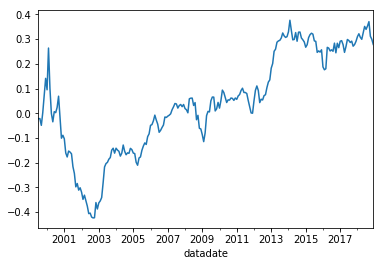

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.141138
2000-12-31   -0.202045
2001-12-31   -0.233477
2002-12-31   -0.123126
2003-12-31    0.369529
2004-12-31    0.017201
2005-12-31    0.074677
2006-12-31    0.072476
2007-12-31    0.053496
2008-12-31   -0.095575
2009-12-31    0.114696
2010-12-31    0.017132
2011-12-31   -0.058126
2012-12-31    0.135023
2013-12-31    0.154470
2014-12-31   -0.016564
2015-12-31   -0.024593
2016-12-31    0.006857
2017-12-31    0.020291
2018-12-31   -0.009736
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     56.64
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.63e-33
Time:                        22:52:24   Log-Likelihood:                 556.20
No. Observations:                 234   AIC:                            -1102.
Df Residuals:                     229   BIC:                            -1085.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.958      0.339      -0.002       0.005
mktrf          0.1655      0.042      3.908      0.000       0.082       0.249
me             0.2723      0.049      5.528      0.000       0.175       0.369
ia            -0.1877      0.075     -2.507      0.013      -0.335      -0.040
roe           -0.3525      0.064     -5.501      0.000      -0.479      -0.226
==============================================================================
Omnibus:                       19.829   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.736
Skew:                           0.237   Prob(JB):                     1.07e-13
Kurtosis:                       5.429   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     26.94
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.51e-18
Time:                        22:52:24   Log-Likelihood:                 556.20
No. Observations:                 234   AIC:                            -1102.
Df Residuals:                     229   BIC:                            -1085.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.756      0.450      -0.002       0.005
mktrf          0.1655      0.055      3.022      0.003       0.058       0.273
me             0.2723      0.090      3.026      0.002       0.096       0.449
ia            -0.1877      0.117     -1.611      0.107      -0.416       0.041
roe           -0.3525      0.102     -3.464      0.001      -0.552      -0.153
==============================================================================
Omnibus:                       19.829   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.736
Skew:                           0.237   Prob(JB):                     1.07e-13
Kurtosis:                       5.429   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     31.89
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.01e-21
Time:                        22:52:24   Log-Likelihood:                 556.20
No. Observations:                 234   AIC:                            -1102.
Df Residuals:                     229   BIC:                            -1085.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.701      0.483      -0.003       0.006
mktrf          0.1655      0.043      3.816      0.000       0.080       0.251
me             0.2723      0.089      3.067      0.002       0.098       0.446
ia            -0.1877      0.097     -1.928      0.054      -0.378       0.003
roe           -0.3525      0.099     -3.567      0.000      -0.546      -0.159
==============================================================================
Omnibus:                       19.829   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.736
Skew:                           0.237   Prob(JB):                     1.07e-13
Kurtosis:                       5.429   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     58.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.63e-39
Time:                        22:52:24   Log-Likelihood:                 572.71
No. Observations:                 234   AIC:                            -1133.
Df Residuals:                     228   BIC:                            -1113.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.478      0.141      -0.001       0.005
mktrf          0.1756      0.040      4.430      0.000       0.097       0.254
smb            0.1862      0.052      3.561      0.000       0.083       0.289
hml           -0.0913      0.062     -1.481      0.140      -0.213       0.030
rmw           -0.5025      0.070     -7.208      0.000      -0.640      -0.365
cma            0.0765      0.089      0.863      0.389      -0.098       0.251
==============================================================================
Omnibus:                       12.068   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               27.566
Skew:                           0.096   Prob(JB):                     1.03e-06
Kurtosis:                       4.671   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     42.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.47e-30
Time:                        22:52:24   Log-Likelihood:                 572.71
No. Observations:                 234   AIC:                            -1133.
Df Residuals:                     228   BIC:                            -1113.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.543      0.123      -0.001       0.005
mktrf          0.1756      0.043      4.083      0.000       0.091       0.260
smb            0.1862      0.050      3.723      0.000       0.088       0.284
hml           -0.0913      0.064     -1.434      0.152      -0.216       0.034
rmw           -0.5025      0.065     -7.672      0.000      -0.631      -0.374
cma            0.0765      0.106      0.723      0.469      -0.131       0.284
==============================================================================
Omnibus:                       12.068   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               27.566
Skew:                           0.096   Prob(JB):                     1.03e-06
Kurtosis:                       4.671   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     57.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.10e-38
Time:                        22:52:24   Log-Likelihood:                 572.71
No. Observations:                 234   AIC:                            -1133.
Df Residuals:                     228   BIC:                            -1113.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.531      0.126      -0.001       0.005
mktrf          0.1756      0.039      4.476      0.000       0.099       0.252
smb            0.1862      0.041      4.517      0.000       0.105       0.267
hml           -0.0913      0.052     -1.773      0.076      -0.192       0.010
rmw           -0.5025      0.065     -7.734      0.000      -0.630      -0.375
cma            0.0765      0.100      0.766      0.444      -0.119       0.272
==============================================================================
Omnibus:                       12.068   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               27.566
Skew:                           0.096   Prob(JB):                     1.03e-06
Kurtosis:                       4.671   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     49.26
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.24e-30
Time:                        22:52:24   Log-Likelihood:                 548.37
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     229   BIC:                            -1069.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.203      0.840      -0.003       0.003
mktrf          0.2977      0.040      7.384      0.000       0.218       0.377
smb            0.3547      0.050      7.048      0.000       0.256       0.454
hml           -0.1625      0.050     -3.251      0.001      -0.261      -0.064
umd           -0.0076      0.033     -0.233      0.816      -0.072       0.057
==============================================================================
Omnibus:                       18.494   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.488
Skew:                           0.395   Prob(JB):                     1.19e-08
Kurtosis:                       4.766   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     25.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.40e-17
Time:                        22:52:24   Log-Likelihood:                 548.37
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     229   BIC:                            -1069.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.174      0.862      -0.004       0.003
mktrf          0.2977      0.047      6.379      0.000       0.206       0.389
smb            0.3547      0.082      4.337      0.000       0.194       0.515
hml           -0.1625      0.060     -2.700      0.007      -0.281      -0.045
umd           -0.0076      0.057     -0.134      0.893      -0.119       0.104
==============================================================================
Omnibus:                       18.494   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.488
Skew:                           0.395   Prob(JB):                     1.19e-08
Kurtosis:                       4.766   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     25.79
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-17
Time:                        22:52:24   Log-Likelihood:                 548.37
No. Observations:                 234   AIC:                            -1087.
Df Residuals:                     229   BIC:                            -1069.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.163      0.871      -0.004       0.004
mktrf          0.2977      0.043      6.972      0.000       0.214       0.381
smb            0.3547      0.065      5.454      0.000       0.227       0.482
hml           -0.1625      0.055     -2.969      0.003      -0.270      -0.055
umd           -0.0076      0.061     -0.125      0.901      -0.128       0.112
==============================================================================
Omnibus:                       18.494   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.488
Skew:                           0.395   Prob(JB):                     1.19e-08
Kurtosis:                       4.766   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     31.31
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-17
Time:                        22:52:24   Log-Likelihood:                 262.80
No. Observations:                 120   AIC:                            -515.6
Df Residuals:                     115   BIC:                            -501.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.003      0.328      0.744      -0.004       0.006
mktrf          0.2142      0.071      3.004      0.003       0.073       0.355
me             0.3418      0.070      4.854      0.000       0.202       0.481
ia            -0.2050      0.110     -1.859      0.066      -0.423       0.013
roe           -0.2580      0.098     -2.643      0.009      -0.451      -0.065
==============================================================================
Omnibus:                       10.763   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.338
Skew:                           0.398   Prob(JB):                     0.000172
Kurtosis:                       4.684   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     17.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.88e-11
Time:                        22:52:24   Log-Likelihood:                 262.80
No. Observations:                 120   AIC:                            -515.6
Df Residuals:                     115   BIC:                            -501.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.004      0.235      0.814      -0.006       0.008
mktrf          0.2142      0.094      2.269      0.023       0.029       0.399
me             0.3418      0.112      3.041      0.002       0.122       0.562
ia            -0.2050      0.157     -1.310      0.190      -0.512       0.102
roe           -0.2580      0.147     -1.753      0.080      -0.546       0.030
==============================================================================
Omnibus:                       10.763   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.338
Skew:                           0.398   Prob(JB):                     0.000172
Kurtosis:                       4.684   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     20.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.59e-13
Time:                        22:52:24   Log-Likelihood:                 262.80
No. Observations:                 120   AIC:                            -515.6
Df Residuals:                     115   BIC:                            -501.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.004      0.217      0.828      -0.007       0.009
mktrf          0.2142      0.077      2.770      0.006       0.063       0.366
me             0.3418      0.113      3.031      0.002       0.121       0.563
ia            -0.2050      0.136     -1.504      0.133      -0.472       0.062
roe           -0.2580      0.135     -1.907      0.057      -0.523       0.007
==============================================================================
Omnibus:                       10.763   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               17.338
Skew:                           0.398   Prob(JB):                     0.000172
Kurtosis:                       4.684   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     36.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.40e-22
Time:                        22:52:24   Log-Likelihood:                 275.51
No. Observations:                 120   AIC:                            -539.0
Df Residuals:                     114   BIC:                            -522.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.249      0.214      -0.002       0.008
mktrf          0.1982      0.068      2.918      0.004       0.064       0.333
smb            0.2199      0.077      2.858      0.005       0.067       0.372
hml           -0.1184      0.094     -1.255      0.212      -0.305       0.068
rmw           -0.4622      0.111     -4.158      0.000      -0.682      -0.242
cma            0.0953      0.122      0.783      0.435      -0.146       0.337
==============================================================================
Omnibus:                        4.722   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.347
Skew:                           0.068   Prob(JB):                       0.0419
Kurtosis:                       4.118   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     43.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.91e-25
Time:                        22:52:24   Log-Likelihood:                 275.51
No. Observations:                 120   AIC:                            -539.0
Df Residuals:                     114   BIC:                            -522.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.003      1.193      0.233      -0.002       0.008
mktrf          0.1982      0.070      2.848      0.004       0.062       0.335
smb            0.2199      0.072      3.057      0.002       0.079       0.361
hml           -0.1184      0.090     -1.308      0.191      -0.296       0.059
rmw           -0.4622      0.109     -4.245      0.000      -0.676      -0.249
cma            0.0953      0.120      0.797      0.425      -0.139       0.330
==============================================================================
Omnibus:                        4.722   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.347
Skew:                           0.068   Prob(JB):                       0.0419
Kurtosis:                       4.118   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     65.92
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.00e-32
Time:                        22:52:24   Log-Likelihood:                 275.51
No. Observations:                 120   AIC:                            -539.0
Df Residuals:                     114   BIC:                            -522.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.003      1.205      0.228      -0.002       0.008
mktrf          0.1982      0.059      3.379      0.001       0.083       0.313
smb            0.2199      0.060      3.646      0.000       0.102       0.338
hml           -0.1184      0.065     -1.825      0.068      -0.245       0.009
rmw           -0.4622      0.105     -4.423      0.000      -0.667      -0.257
cma            0.0953      0.105      0.911      0.362      -0.110       0.300
==============================================================================
Omnibus:                        4.722   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.347
Skew:                           0.068   Prob(JB):                       0.0419
Kurtosis:                       4.118   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     34.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.26e-19
Time:                        22:52:24   Log-Likelihood:                 265.68
No. Observations:                 120   AIC:                            -521.4
Df Residuals:                     115   BIC:                            -507.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.207      0.836      -0.004       0.006
mktrf          0.3610      0.061      5.887      0.000       0.240       0.483
smb            0.3669      0.070      5.254      0.000       0.229       0.505
hml           -0.1915      0.070     -2.738      0.007      -0.330      -0.053
umd            0.0218      0.043      0.505      0.614      -0.064       0.107
==============================================================================
Omnibus:                       10.840   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.062
Skew:                           0.501   Prob(JB):                     0.000884
Kurtosis:                       4.345   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     27.39
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.66e-16
Time:                        22:52:24   Log-Likelihood:                 265.68
No. Observations:                 120   AIC:                            -521.4
Df Residuals:                     115   BIC:                            -507.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.169      0.866      -0.006       0.007
mktrf          0.3610      0.064      5.685      0.000       0.237       0.486
smb            0.3669      0.094      3.900      0.000       0.183       0.551
hml           -0.1915      0.074     -2.593      0.010      -0.336      -0.047
umd            0.0218      0.063      0.344      0.731      -0.102       0.146
==============================================================================
Omnibus:                       10.840   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.062
Skew:                           0.501   Prob(JB):                     0.000884
Kurtosis:                       4.345   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     36.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-19
Time:                        22:52:24   Log-Likelihood:                 265.68
No. Observations:                 120   AIC:                            -521.4
Df Residuals:                     115   BIC:                            -507.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.160      0.873      -0.006       0.007
mktrf          0.3610      0.049      7.308      0.000       0.264       0.458
smb            0.3669      0.071      5.168      0.000       0.228       0.506
hml           -0.1915      0.064     -3.015      0.003      -0.316      -0.067
umd            0.0218      0.065      0.338      0.736      -0.105       0.148
==============================================================================
Omnibus:                       10.840   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               14.062
Skew:                           0.501   Prob(JB):                     0.000884
Kurtosis:                       4.345   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     25.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.19e-15
Time:                        22:52:24   Log-Likelihood:                 315.29
No. Observations:                 114   AIC:                            -620.6
Df Residuals:                     109   BIC:                            -606.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.002      1.150      0.253      -0.001       0.005
mktrf          0.1627      0.046      3.553      0.001       0.072       0.253
me             0.0787      0.071      1.113      0.268      -0.061       0.219
ia            -0.1674      0.098     -1.707      0.091      -0.362       0.027
roe           -0.5401      0.086     -6.269      0.000      -0.711      -0.369
==============================================================================
Omnibus:                        2.107   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                2.073
Skew:                           0.321   Prob(JB):                        0.355
Kurtosis:                       2.843   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     48.97
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.62e-23
Time:                        22:52:24   Log-Likelihood:                 315.29
No. Observations:                 114   AIC:                            -620.6
Df Residuals:                     109   BIC:                            -606.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.409      0.159      -0.001       0.004
mktrf          0.1627      0.044      3.730      0.000       0.077       0.248
me             0.0787      0.041      1.900      0.057      -0.002       0.160
ia            -0.1674      0.095     -1.766      0.077      -0.353       0.018
roe           -0.5401      0.076     -7.074      0.000      -0.690      -0.390
==============================================================================
Omnibus:                        2.107   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                2.073
Skew:                           0.321   Prob(JB):                        0.355
Kurtosis:                       2.843   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     76.65
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.65e-31
Time:                        22:52:24   Log-Likelihood:                 315.29
No. Observations:                 114   AIC:                            -620.6
Df Residuals:                     109   BIC:                            -606.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.339      0.181      -0.001       0.004
mktrf          0.1627      0.042      3.909      0.000       0.081       0.244
me             0.0787      0.037      2.138      0.033       0.007       0.151
ia            -0.1674      0.092     -1.821      0.069      -0.347       0.013
roe           -0.5401      0.069     -7.862      0.000      -0.675      -0.405
==============================================================================
Omnibus:                        2.107   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                2.073
Skew:                           0.321   Prob(JB):                        0.355
Kurtosis:                       2.843   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     14.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.61e-11
Time:                        22:52:24   Log-Likelihood:                 307.49
No. Observations:                 114   AIC:                            -603.0
Df Residuals:                     108   BIC:                            -586.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.510      0.611      -0.002       0.004
mktrf          0.1865      0.047      3.969      0.000       0.093       0.280
smb            0.0962      0.076      1.261      0.210      -0.055       0.247
hml           -0.0485      0.097     -0.499      0.619      -0.241       0.144
rmw           -0.5414      0.119     -4.546      0.000      -0.777      -0.305
cma            0.0214      0.151      0.141      0.888      -0.278       0.321
==============================================================================
Omnibus:                        4.457   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                5.587
Skew:                           0.106   Prob(JB):                       0.0612
Kurtosis:                       4.063   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     10.29
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.39e-08
Time:                        22:52:24   Log-Likelihood:                 307.49
No. Observations:                 114   AIC:                            -603.0
Df Residuals:                     108   BIC:                            -586.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.736      0.462      -0.001       0.003
mktrf          0.1865      0.050      3.733      0.000       0.089       0.284
smb            0.0962      0.058      1.649      0.099      -0.018       0.210
hml           -0.0485      0.088     -0.551      0.582      -0.221       0.124
rmw           -0.5414      0.134     -4.042      0.000      -0.804      -0.279
cma            0.0214      0.168      0.128      0.898      -0.307       0.350
==============================================================================
Omnibus:                        4.457   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                5.587
Skew:                           0.106   Prob(JB):                       0.0612
Kurtosis:                       4.063   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     20.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.31e-14
Time:                        22:52:24   Log-Likelihood:                 307.49
No. Observations:                 114   AIC:                            -603.0
Df Residuals:                     108   BIC:                            -586.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.757      0.449      -0.001       0.003
mktrf          0.1865      0.049      3.770      0.000       0.090       0.283
smb            0.0962      0.049      1.958      0.050   -7.59e-05       0.192
hml           -0.0485      0.098     -0.495      0.621      -0.241       0.144
rmw           -0.5414      0.133     -4.075      0.000      -0.802      -0.281
cma            0.0214      0.182      0.118      0.906      -0.335       0.378
==============================================================================
Omnibus:                        4.457   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                5.587
Skew:                           0.106   Prob(JB):                       0.0612
Kurtosis:                       4.063   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     11.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.26e-07
Time:                        22:52:24   Log-Likelihood:                 297.48
No. Observations:                 114   AIC:                            -585.0
Df Residuals:                     109   BIC:                            -571.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.26e-05      0.002     -0.024      0.981      -0.004       0.004
mktrf          0.2209      0.051      4.355      0.000       0.120       0.321
smb            0.2068      0.079      2.614      0.010       0.050       0.364
hml            0.0051      0.081      0.063      0.950      -0.156       0.167
umd           -0.0543      0.061     -0.883      0.379      -0.176       0.068
==============================================================================
Omnibus:                        5.728   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                7.817
Skew:                           0.183   Prob(JB):                       0.0201
Kurtosis:                       4.229   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     10.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.15e-07
Time:                        22:52:24   Log-Likelihood:                 297.48
No. Observations:                 114   AIC:                            -585.0
Df Residuals:                     109   BIC:                            -571.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.26e-05      0.001     -0.030      0.976      -0.003       0.003
mktrf          0.2209      0.049      4.502      0.000       0.125       0.317
smb            0.2068      0.070      2.958      0.003       0.070       0.344
hml            0.0051      0.094      0.055      0.956      -0.179       0.189
umd           -0.0543      0.072     -0.750      0.453      -0.196       0.087
==============================================================================
Omnibus:                        5.728   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                7.817
Skew:                           0.183   Prob(JB):                       0.0201
Kurtosis:                       4.229   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     11.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.58e-08
Time:                        22:52:24   Log-Likelihood:                 297.48
No. Observations:                 114   AIC:                            -585.0
Df Residuals:                     109   BIC:                            -571.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.26e-05      0.001     -0.031      0.976      -0.003       0.003
mktrf          0.2209      0.045      4.961      0.000       0.134       0.308
smb            0.2068      0.067      3.087      0.002       0.076       0.338
hml            0.0051      0.095      0.054      0.957      -0.180       0.191
umd           -0.0543      0.070     -0.771      0.441      -0.192       0.084
==============================================================================
Omnibus:                        5.728   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                7.817
Skew:                           0.183   Prob(JB):                       0.0201
Kurtosis:                       4.229   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""